### Bibliotecas

In [6]:
import pandas as pd
import geopandas as gpd
import os

### Localização dos arquivos

In [170]:
arquivo_cge = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Alagamentos_CGESP/Alagamentos_SP_2015.csv'

diretorio_incidentes = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_riscoocorrencia/'

### Carregamento e validações dos incidentes do Geosampa

In [202]:
def listar_shp(diretorio):
    arquivos_csv = []
    
    # Percorre os arquivos no diretório fornecido
    for arquivo in os.listdir(diretorio):
        # Verifica se o arquivo tem extensão .csv
        # Observe que os arquivos serão filtrados somente para o ano de 2023.
        if arquivo.endswith("2023.shp"):
            arquivos_csv.append(arquivo)
            
     # Ordena a lista de arquivos com base nos quatro últimos dígitos (o ano)
    arquivos_csv.sort(key=lambda x: int(x[-8:-4]))  # Captura os quatro últimos dígitos antes da extensão .csv
    
    return arquivos_csv

In [203]:
def processar_shp(diretorio):
    arquivos_shp = listar_shp(diretorio)
    dataframes = []  # Lista para armazenar os DataFrames processados

    for arquivo in arquivos_shp:
        caminho_arquivo = os.path.join(diretorio, arquivo)
        #print(caminho_arquivo)
        
        # Carrega o SHP e processa as colunas de Data e Horário
        gdf_incidentes = gpd.read_file(caminho_arquivo)

        # Lista de valores que você deseja excluir
        valores_excluir = ['QUEDA DE ARVORE', 'DESLIZAMENTO']

        # Excluir os valores indesejados diretamente no próprio gdf
        gdf_incidentes = gdf_incidentes[~gdf_incidentes['ocorrencia'].isin(valores_excluir)]

        # Convertendo a coluna 'Data' para datetime
        #formato_data = '%d/%m/%y'
        formato_data = '%Y-%m-%d'

        gdf_incidentes['data'] = pd.to_datetime(gdf_incidentes['data'], format=formato_data)

        # Adiciona o DataFrame processado à lista
        dataframes.append(gdf_incidentes)

        # Concatena todos os DataFrames em um único DataFrame
        df_final = pd.concat(dataframes, ignore_index=True)
    
    return df_final

In [213]:
# Exemplo de uso
gdf_geosampa = gpd.GeoDataFrame() # Apenas para limpar o dataframe
gdf_geosampa = processar_shp(diretorio_incidentes)

In [214]:
gdf_geosampa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        803 non-null    datetime64[ms]
 1   ocorrencia  803 non-null    object        
 2   subpreit    803 non-null    object        
 3   name        803 non-null    object        
 4   geometry    803 non-null    geometry      
dtypes: datetime64[ms](1), geometry(1), object(3)
memory usage: 31.5+ KB


In [215]:
gdf_geosampa.head(10)

,data,ocorrencia,subpreit,name,geometry
0,2023-02-01,ALAGAMENTO,ST - SANTANA-TUCURUVI,29910549,POINT (334269.791 7400916.23)
1,2023-02-01,INUNDACAO,IQ - ITAQUERA,29910580,POINT (351422.442 7398375.396)
2,2023-02-01,ALAGAMENTO,IQ - ITAQUERA,29910598,POINT (353288.721 7390108.439)
3,2023-02-01,ALAGAMENTO,MP - SAO MIGUEL,29910602,POINT (350820.931 7402080.448)
4,2023-02-01,INUNDACAO,SM - SAO MATEUS,29911071,POINT (353084.744 7390212.824)
5,2023-02-01,INUNDACAO,MP - SAO MIGUEL,29911170,POINT (351366.422 7401519.18)
6,2023-02-01,INUNDACAO,PR - PERUS,29911251,POINT (315503.829 7406528.465)
7,2023-02-01,INUNDACAO,SM - SAO MATEUS,29911514,POINT (351452.584 7385738.89)
8,2023-02-01,ALAGAMENTO,IQ - ITAQUERA,29912171,POINT (350360.392 7393708.581)
9,2023-02-01,INUNDACAO,CT - CIDADE TIRADENTES,29913695,POINT (358311.623 7392391.098)


### Validações estatísticas no arquivo do Geosampa

In [216]:
# Extraindo o ano da coluna 'Data'
gdf_geosampa['Ano'] = gdf_geosampa['data'].dt.year
gdf_geosampa['Mês'] = gdf_geosampa['data'].dt.month
    
# Agrupando pelo ano e contando o número de ocorrências
total_por_mes_ano = gdf_geosampa.groupby(['Ano', 'Mês']).size()

# Usando unstack para colocar os meses na horizontal
total_por_mes_ano_horizontal = total_por_mes_ano.unstack(fill_value=0)    

print('Série histórica: número de eventos registrados por mês')
print(total_por_mes_ano_horizontal)

Série histórica: número de eventos registrados por mês
Mês    1    2    3   4   5   6   8   9   10  11  12
Ano                                                
2023  175  266  183  20   2   3   4   7  69  28  46


In [217]:
# Extraindo o ano e o mês da coluna 'data'
gdf_geosampa['Ano'] = gdf_geosampa['data'].dt.year
gdf_geosampa['Mês'] = gdf_geosampa['data'].dt.month
gdf_geosampa['Dia'] = gdf_geosampa['data'].dt.day

# Agrupando por ano e mês e contando os dias únicos
dias_unicos_por_mes_ano = gdf_geosampa.groupby(['Ano', 'Mês'])['Dia'].nunique()

# Usando unstack para colocar os meses na horizontal
dias_unicos_por_mes_ano_horizontal = dias_unicos_por_mes_ano.unstack(fill_value=0)

# Exibindo o resultado
print('Série histórica: dias únicos de alagamento, por mês. Fonte: GeoSampa')
print(dias_unicos_por_mes_ano_horizontal)

Série histórica: dias únicos de alagamento, por mês. Fonte: GeoSampa
Mês   1   2   3   4   5   6   8   9   10  11  12
Ano                                             
2023  18  28  20   7   2   3   4   4  15  10  12


### Carregamento dos dados de alagamento do CGE-SP

In [219]:
diretorio_cge = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Alagamentos_CGESP'

In [220]:
def listar_csv(diretorio):
    arquivos_csv = []
    
    # Percorre os arquivos no diretório fornecido
    for arquivo in os.listdir(diretorio):
        # Verifica se o arquivo tem extensão .csv
        # Reparar que os dados estão filtrados
        if arquivo.endswith("2023.csv"):
            arquivos_csv.append(arquivo)
            
     # Ordena a lista de arquivos com base nos quatro últimos dígitos (o ano)
    arquivos_csv.sort(key=lambda x: int(x[-8:-4]))  # Captura os quatro últimos dígitos antes da extensão .csv
    
    return arquivos_csv

In [221]:
def processar_csv(diretorio):
    arquivos_csv = listar_csv(diretorio)
    dataframes = []  # Lista para armazenar os DataFrames processados

    for arquivo in arquivos_csv:
        caminho_arquivo = os.path.join(diretorio, arquivo)

        # Carrega o CSV e processa as colunas de Data e Horário
        df_cge = pd.read_csv(caminho_arquivo, sep=';')

        # Convertendo a coluna 'Data' para datetime
        formato_data = '%d/%m/%y'
        df_cge['Data'] = pd.to_datetime(df_cge['Data'], format=formato_data)

        # Convertendo as colunas 'Horário Inicial' e 'Horário Final' para time
        df_cge['Horário Inicial'] = pd.to_datetime(df_cge['Horário Inicial'], format='%H:%M').dt.time
        df_cge['Horário Final'] = pd.to_datetime(df_cge['Horário Final'], format='%H:%M').dt.time

        # Adiciona o DataFrame processado à lista
        dataframes.append(df_cge)

        # Concatena todos os DataFrames em um único DataFrame
        df_final = pd.concat(dataframes, ignore_index=True)
    
    return df_final

In [222]:
# Exemplo de uso
df_cge_processados = processar_csv(diretorio_cge)

In [223]:
# Exemplo para exibir o primeiro DataFrame
print(df_cge_processados.head())

   Unnamed: 0       Data  Alagamento    Bairro                   Tipo  \
0           0 2023-01-01           1  Itaquera  Inativo Intransitável   
1           1 2023-01-01           1  Itaquera    Inativo Transitável   
2           2 2023-01-01           1  Itaquera    Inativo Transitável   
3           3 2023-01-01           1  Itaquera    Inativo Transitável   
4           4 2023-01-01           1  Itaquera    Inativo Transitável   

  Horário Inicial Horário Final                     Endereço  \
0        14:16:00      14:48:00           AVENIDA ARICANDUVA   
1        14:35:00      17:55:00  RUA PADRE VIEGAS DE MENEZES   
2        14:35:00      17:55:00  RUA PADRE VIEGAS DE MENEZES   
3        14:35:00      17:55:00  RUA PADRE VIEGAS DE MENEZES   
4        14:35:00      17:55:00  RUA PADRE VIEGAS DE MENEZES   

              Sentido                          Referência  
0   ITAQUERA/MARGINAL   AVENIDA AFONSO DE SAMPAIO E SOUZA  
1               UNICO                      RUA ITAGIMIRI

In [184]:
# Salvando o DataFrame em um arquivo CSV
df_cge_processados.to_csv('alagamentos_cge_1324.csv', index=True)

### Validações estatísticas no arquivo do CGE-SP

In [224]:
df_cge_processados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       893 non-null    int64         
 1   Data             893 non-null    datetime64[ns]
 2   Alagamento       893 non-null    int64         
 3   Bairro           893 non-null    object        
 4   Tipo             893 non-null    object        
 5   Horário Inicial  893 non-null    object        
 6   Horário Final    893 non-null    object        
 7   Endereço         893 non-null    object        
 8   Sentido          893 non-null    object        
 9   Referência       893 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 69.9+ KB


In [225]:
# Extraindo o ano da coluna 'Data'
df_cge_processados['Ano'] = df_cge_processados['Data'].dt.year
df_cge_processados['Mês'] = df_cge_processados['Data'].dt.month
    
# Agrupando pelo ano e contando o número de ocorrências
total_por_mes_ano = df_cge_processados.groupby(['Ano', 'Mês']).size()

# Usando unstack para colocar os meses na horizontal
total_por_mes_ano_horizontal = total_por_mes_ano.unstack(fill_value=0)    

print(total_por_mes_ano_horizontal)

Mês    1    2    3   4   5   6   8   9    10  11  12
Ano                                                 
2023  145  242  214  45   5   4   5  11  116  64  42


In [226]:
# Extraindo o ano da coluna 'Data'
df_cge_processados['Ano'] = df_cge_processados['Data'].dt.year
df_cge_processados['Mês'] = df_cge_processados['Data'].dt.month
df_cge_processados['Dia'] = df_cge_processados['Data'].dt.day
    
# Agrupando pelo ano e contando o número de ocorrências
dias_unicos_por_mes_ano = df_cge_processados.groupby(['Ano', 'Mês'])['Dia'].nunique()

# Usando unstack para colocar os meses na horizontal
dias_unicos_por_mes_ano_horizontal = dias_unicos_por_mes_ano.unstack(fill_value=0) 

print('Série histórica: dias únicos de alagamento, por mês. Fonte: CGE')
print(dias_unicos_por_mes_ano_horizontal)

Série histórica: dias únicos de alagamento, por mês. Fonte: CGE
Mês   1   2   3   4   5   6   8   9   10  11  12
Ano                                             
2023  19  17  12   2   1   2   3   4  13   7   6


### Carregamento dos dados de pluviometria

In [92]:
arquivo_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023/dados_cge___P400_Riacho_Grande.csv'

diretório_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023/'


In [123]:
# Indicador numérico dos postos:
postos = [503, 1000866, 495, 1000840, 1000854, 1000850, 1000852, 634, 592, 846, 507, 1000300, 1000860, 1000887, 1000859, 524, 1000864, 1000844, 1000862, 1000882, 1000635, 1000842, 1000848, 504, 515, 509, 1000944, 540, 510, 400, 1000876]

# Dados fornecidos (reutilizados):
names = [
    "Sé - CGE (PMSP/SE-01)", "Sé - Anhembi (PMSP/SE-02)", "Vila Mariana (PMSP/VM-01)", 
    "Ipiranga (PMSP/IP-01)", "Campo Limpo (PMSP/CL-03)", "M Boi Mirim (PMSP/MB-01)", 
    "Santo Amaro (PMSP/SA-01)", "Jabaquara (PMSP/JA-01)", "Cidade Ademar - (PMSP/AD-01) / São Paulo", 
    "Capela do Socorro (PMSP/CS-01)", "Parelheiros - Barragem (PMSP/PA-01)", 
    "Estação Meteorológica Marsilac", "Mooca (PMSP/MO-01)", "Penha - Rincão (PMSP/PE-01)", 
    "Aricanduva - Vila Formosa (PMSP/AF-02)", "Vila Prudente - (PMSP/VP-01)", "Itaquera (PMSP/IQ-02)", 
    "São Mateus (PMSP/SM-05)", "São Miguel Paulista (PMSP/MP-01)", "Itaim Paulista (PMSP/IT-01)", 
    "Pinheiros (PMSP/PI-01)", "Butantã (PMSP/BT-02)", "Lapa (PMSP/LA-01)", "Perus (PMSP/PR-01)", 
    "Pirituba (PMSP/PJ-01)", "Freguesia do Ó (PMSP/FO-01)", "Tremembé (PMSP/JT-01)", 
    "Vila Maria - Vila Guilherme (PMSP/MG-01)", "Santana/Tucuruvi - COMDEC (PMSP/ST-01)", 
    "Riacho Grande", "Mauá - Paço Municipal"
]

# Exemplo de lista adicional de estações:
estacoes = ['0', '1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','30','31']

# Índices
indices = list(range(len(names)))

# Criar dicionário com o formato {index: {name, estacao, posto}}
dicionario_estacoes = {
    i: {'Name': names[i], 'Estacao': estacoes[i], 'Posto': postos[i]} 
    for i in indices
}

# Exibir o dicionário
dicionario_estacoes

{0: {'Name': 'Sé - CGE (PMSP/SE-01)', 'Estacao': '0', 'Posto': 503},
 1: {'Name': 'Sé - Anhembi (PMSP/SE-02)', 'Estacao': '1', 'Posto': 1000866},
 2: {'Name': 'Vila Mariana (PMSP/VM-01)', 'Estacao': '2', 'Posto': 495},
 3: {'Name': 'Ipiranga (PMSP/IP-01)', 'Estacao': '3', 'Posto': 1000840},
 4: {'Name': 'Campo Limpo (PMSP/CL-03)', 'Estacao': '4', 'Posto': 1000854},
 5: {'Name': 'M Boi Mirim (PMSP/MB-01)', 'Estacao': '5', 'Posto': 1000850},
 6: {'Name': 'Santo Amaro (PMSP/SA-01)', 'Estacao': '6', 'Posto': 1000852},
 7: {'Name': 'Jabaquara (PMSP/JA-01)', 'Estacao': '7', 'Posto': 634},
 8: {'Name': 'Cidade Ademar - (PMSP/AD-01) / São Paulo',
  'Estacao': '8',
  'Posto': 592},
 9: {'Name': 'Capela do Socorro (PMSP/CS-01)', 'Estacao': '9', 'Posto': 846},
 10: {'Name': 'Parelheiros - Barragem (PMSP/PA-01)',
  'Estacao': '10',
  'Posto': 507},
 11: {'Name': 'Estação Meteorológica Marsilac',
  'Estacao': '11',
  'Posto': 1000300},
 12: {'Name': 'Mooca (PMSP/MO-01)', 'Estacao': '12', 'Posto': 1

In [93]:
def listar_csv_chuva(diretorio):
    arquivos_csv = []
    
    # Percorre os arquivos no diretório fornecido
    for arquivo in os.listdir(diretorio):
        # Verifica se o arquivo tem extensão .csv
        # Reparar que os dados estão filtrados
        if arquivo.endswith(".csv"):
            arquivos_csv.append(arquivo)
                
    return arquivos_csv

In [94]:
listar_csv_chuva(diretório_chuva)

['dados_cge___P524_Vila_Prudente____PMSP_VP_01_.csv',
 'dados_cge___P1000862_S_o_Miguel_Paulista__PMSP_MP_01_.csv',
 'dados_cge___P1000880_Santana_do_Parna_ba.csv',
 'dados_cge___P509_Freguesia_do____PMSP_FO_01_.csv',
 'dados_cge___P1000876_Mau____Pa_o_Municipal.csv',
 'dados_cge___P1000864_Itaquera__PMSP_IQ_02_.csv',
 'dados_cge___P1000635_Pinheiros__PMSP_PI_01_.csv',
 'dados_cge___P634_Jabaquara__PMSP_JA_01_.csv',
 'dados_cge___P1000860_Mooca__PMSP_MO_01_.csv',
 'dados_cge___P846_Capela_do_Socorro___Subprefeitura__PMSP_CS_01_.csv',
 'dados_cge___P515_Pirituba__PMSP_PJ_01_.csv',
 'dados_cge___P1000854_Campo_Limpo__PMSP_CL_03_.csv',
 'dados_cge___P1000882_Itaim_Paulista__PMSP_IT_01_.csv',
 'dados_cge___P1000300_Esta__o_Meteorol_gica_Marsilac.csv',
 'dados_cge___P1000852_Santo_Amaro__PMSP_SA_01_.csv',
 'dados_cge___P507_Parelheiros___Barragem__PMSP_PA_01_.csv',
 'dados_cge___P1000866_S____Anhembi__PMSP_SE_02_.csv',
 'dados_cge___P592_Cidade_Ademar____PMSP_AD_01____S_o_Paulo.csv',
 'dado

In [115]:
def buscar_estacao_por_posto(dicionario, posto_desejado):
    for info in dicionario.values():
        if info['Posto'] == posto_desejado:
            return info['Estacao']
        else:
            print(f'O posto {posto_desejado} não foi encontrado')
    return "Posto não encontrado"

In [116]:
import os
import pandas as pd
from glob import glob

In [117]:
# Função para processar um único arquivo CSV
def processar_arquivo_chuva(arquivo_chuva):
    # Carregar o CSV
    df_chuva_10min = pd.read_csv(arquivo_chuva, sep=',')
    
    # Verificar se o DataFrame não está vazio
    if df_chuva_10min.empty:
        print(f"Arquivo {arquivo_chuva} está vazio. Pulando.")
        return None
    
    # Selecionar as colunas relevantes
    df_chuva_10min = df_chuva_10min.loc[:, ['DATA', 'Posto', 'PLU(mm)']]
    
    # Converter os valores da coluna 'PLU(mm)' de mm/h para m/h
    df_chuva_10min = converter_mm_para_m(df_chuva_10min, 'PLU(mm)')

    # Converter a coluna 'DATA' para datetime
    df_chuva_10min['DATA'] = pd.to_datetime(df_chuva_10min['DATA'])
    
    # Definir a coluna 'DATA' como índice
    df_chuva_10min.set_index('DATA', inplace=True)
    
    # Somar os valores de 'PLU(mm)' a cada hora e criar um novo DataFrame com os dados agregados
    df_chuva_hora = df_chuva_10min['PLU(mm)'].resample('h').sum().to_frame()
    
    # Capturar o número do posto (assumindo que é o mesmo para todas as linhas)
    numero_posto = df_chuva_10min['Posto'].iloc[0]
    if numero_posto == 400:
        print('Achei um dos perdidos! ', numero_posto)
        
    # Excluir a coluna 'Posto'
    df_chuva_10min.drop(columns=['Posto'], inplace=True)
    
    # Renomear a coluna 'PLU(mm)' para incluir o número do posto
    estacao = buscar_estacao_por_posto(dicionario_estacoes, numero_posto)
    df_chuva_hora.rename(columns={'PLU(mm)': estacao}, inplace=True)
    
    # Criar novas colunas 'Dia' e 'Hora' com base no índice
    df_chuva_hora['Dia'] = df_chuva_hora.index.date
    df_chuva_hora['Hora'] = df_chuva_hora.index.time
    
    return df_chuva_hora

In [118]:
def converter_mm_para_m(df, nome_coluna):
    # Verificar se a coluna existe no DataFrame
    if nome_coluna in df.columns:
        # Converter os valores de mm/h para m/h
        df[nome_coluna] = df[nome_coluna] / 1000
    else:
        print(f"Coluna '{nome_coluna}' não encontrada no DataFrame.")
    
    return df

In [124]:
# Função para processar todos os arquivos CSV em um diretório
def processar_todos_arquivos_chuva(diretorio):
    # Encontrar todos os arquivos CSV no diretório
    arquivos_csv = glob(os.path.join(diretorio, '*.csv'))
    
    # Criar uma lista para armazenar os DataFrames processados
    dfs_processados = []
    
    # Iterar sobre todos os arquivos CSV
    for arquivo in arquivos_csv:
        print(f"Processando {arquivo}...")
        df_processado = processar_arquivo_chuva(arquivo)
        if df_processado is not None:
            dfs_processados.append(df_processado)
    
    # Concatenar todos os DataFrames processados (usando join para garantir alinhamento por 'DATA')
    df_final = pd.concat(dfs_processados, axis=1, join='outer')
    
    # Remover possíveis duplicatas no índice
    df_final = df_final[~df_final.index.duplicated(keep='first')]
    
    # Remover colunas desnecessárias (mantendo apenas 'DATA' e os valores de PLU)
    colunas_a_remover = [col for col in df_final.columns if 'Dia' in col or 'Hora' in col]
    df_final = df_final.drop(columns=colunas_a_remover)
    
    # Identificar a primeira coluna como coluna de data, assumindo que seja a primeira coluna do DataFrame
    primeira_coluna = df_final.columns[0]  # Obtenha o nome da primeira coluna

    # Excluir colunas com o título 'Posto não encontrado'
    df_final = df_final.loc[:, ~df_final.columns.str.contains('Posto não encontrado')]

    # Ordenar as colunas numéricas em ordem crescente
    colunas_numericas = sorted([col for col in df_final.columns if col.isnumeric()], key=int)

    # Verificar se a primeira coluna é de datas ou texto e organizar a ordem
    if primeira_coluna not in colunas_numericas:
        # Colocar a primeira coluna (DATA) antes das colunas numéricas ordenadas
        df_final = df_final[[primeira_coluna] + colunas_numericas]
    else:
        # Caso contrário, apenas reordena as colunas numéricas
        df_final = df_final[colunas_numericas]

    return df_final

In [126]:
df_final = processar_todos_arquivos_chuva(diretório_chuva)

# Verificar as primeiras linhas do DataFrame final
df_final

Processando /Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023/dados_cge___P524_Vila_Prudente____PMSP_VP_01_.csv...
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
Processando /Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/mete

,0,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,30,31
DATA,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.002256,0.004700,0.000564,0.003384,0.000940,0.124340,0.118046,0.000000,0.000376,0.000000,...,0.000000,0.004512,0.001692,0.123665,0.000752,0.000000,0.117744,0.002820,0.000376,0.0
2023-01-01 01:00:00,0.001504,0.006768,0.000000,0.002256,0.001692,0.122961,0.116223,0.000000,0.000000,0.000000,...,0.000000,0.003384,0.000188,0.121983,0.000000,0.000000,0.118610,0.005828,0.000752,0.0
2023-01-01 02:00:00,0.003948,0.007520,0.000000,0.002444,0.002444,0.122457,0.117503,0.000376,0.000000,0.000000,...,0.000000,0.001692,0.000564,0.123242,0.000188,0.000000,0.119123,0.001316,0.000752,0.0
2023-01-01 03:00:00,0.004136,0.010152,0.000000,0.002444,0.003196,0.122235,0.118328,0.003008,0.001128,0.000000,...,0.000000,0.004888,0.000000,0.120021,0.000000,0.000000,0.116959,0.007708,0.001880,0.0
2023-01-01 04:00:00,0.000940,0.007144,0.001504,0.002444,0.000940,0.120573,0.114943,0.000000,0.000000,0.000000,...,0.000000,0.002068,0.000000,0.117039,0.000000,0.000000,0.113112,0.004136,0.004888,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-05 14:00:00,0.004324,0.005264,0.000000,0.005828,0.000940,0.131773,0.121581,0.004888,0.009024,0.000000,...,0.006580,0.010904,0.007520,0.142156,0.000000,0.000000,0.135358,0.003384,0.001316,0.0
2023-06-05 15:00:00,0.003196,0.003008,0.000000,0.009400,0.006956,0.140141,0.126094,0.004888,0.008084,0.000000,...,0.004512,0.006392,0.005828,0.146890,0.000000,0.000188,0.140827,0.003008,0.006956,0.0
2023-06-05 16:00:00,0.001504,0.006768,0.000000,0.009588,0.011280,0.145308,0.134240,0.010716,0.008084,0.008460,...,0.003572,0.005452,0.004512,0.152561,0.000000,0.002444,0.141895,0.001692,0.003760,0.0


In [127]:
def adicionar_indexador(df):
    # Cria uma coluna 'indexador' começando em 0 e incrementando 3600 a cada linha
    df['indexador'] = range(0, len(df) * 3600, 3600)
    return df

In [128]:
df_final = adicionar_indexador(df_final)

In [129]:
# Pegando todas as colunas do DataFrame
colunas = df_final.columns.tolist()
    
# Movendo a coluna 'indexador' para ser a segunda
colunas.remove('indexador')
nova_ordem = ['indexador'] + colunas

# Reordenando o DataFrame
df_final = df_final[nova_ordem]

In [134]:
# Salvar o DataFrame como CSV
df_final.to_csv('Rain_source_2023.csv', index=False)

In [133]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3739 entries, 2023-01-01 00:00:00 to 2023-06-05 18:00:00
Freq: h
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   indexador  3739 non-null   int64  
 1   0          3739 non-null   float64
 2   2          3739 non-null   float64
 3   3          3739 non-null   float64
 4   4          3739 non-null   float64
 5   5          3739 non-null   float64
 6   6          3739 non-null   float64
 7   7          3739 non-null   float64
 8   8          3739 non-null   float64
 9   9          3739 non-null   float64
 10  10         3739 non-null   float64
 11  11         3739 non-null   float64
 12  12         3739 non-null   float64
 13  13         3739 non-null   float64
 14  14         3739 non-null   float64
 15  15         3739 non-null   float64
 16  16         3739 non-null   float64
 17  17         3739 non-null   float64
 18  18         3739 non-null   float64
 19  19  

In [62]:
arquivo_teste = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023/dados_cge___P509_Freguesia_do____PMSP_FO_01_.csv'

In [63]:
# Carrega o CSV e processa as colunas de Data e Horário
df_chuva_10min_teste = pd.read_csv(arquivo_teste, sep=',')

# Selecionar as colunas 'DATA', 'Posto' e 'PLU(mm)' e remover as demais
df_chuva_10min_teste = df_chuva_10min_teste.loc[:, ['DATA', 'Posto', 'PLU(mm)']]

# Verificar as primeiras linhas do DataFrame para garantir que as colunas foram mantidas
print(df_chuva_10min_teste.head())

                  DATA  Posto  PLU(mm)
0  2023-01-01 00:00:00    509    0.000
1  2023-01-01 00:10:00    509    0.000
2  2023-01-01 00:20:00    509    0.752
3  2023-01-01 00:30:00    509    0.000
4  2023-01-01 00:40:00    509    0.000


In [66]:
# Definir a coluna 'DATA' como índice
df_chuva_10min_teste.set_index('DATA', inplace=True)

# Somar somente a coluna 'PLU(mm)' a cada hora
df_chuva_agregada = df_chuva_10min_teste['PLU(mm)'].resample('h').sum()


KeyError: "None of ['DATA'] are in the columns"

{0: {'Name': 'Sé - CGE (PMSP/SE-01)', 'Estacao': '0', 'Posto': 503}, 1: {'Name': 'Sé - Anhembi (PMSP/SE-02)', 'Estacao': '1', 'Posto': 1000866}, 2: {'Name': 'Vila Mariana (PMSP/VM-01)', 'Estacao': '2', 'Posto': 495}, 3: {'Name': 'Ipiranga (PMSP/IP-01)', 'Estacao': '3', 'Posto': 1000840}, 4: {'Name': 'Campo Limpo (PMSP/CL-03)', 'Estacao': '4', 'Posto': 1000854}, 5: {'Name': 'M Boi Mirim (PMSP/MB-01)', 'Estacao': '5', 'Posto': 1000850}, 6: {'Name': 'Santo Amaro (PMSP/SA-01)', 'Estacao': '6', 'Posto': 1000852}, 7: {'Name': 'Jabaquara (PMSP/JA-01)', 'Estacao': '7', 'Posto': 634}, 8: {'Name': 'Cidade Ademar - (PMSP/AD-01) / São Paulo', 'Estacao': '8', 'Posto': 592}, 9: {'Name': 'Capela do Socorro (PMSP/CS-01)', 'Estacao': '9', 'Posto': 846}, 10: {'Name': 'Parelheiros - Barragem (PMSP/PA-01)', 'Estacao': '10', 'Posto': 507}, 11: {'Name': 'Estação Meteorológica Marsilac', 'Estacao': '11', 'Posto': 1000300}, 12: {'Name': 'Mooca (PMSP/MO-01)', 'Estacao': '12', 'Posto': 1000860}, 13: {'Name': 'P

In [90]:
# Exemplo de uso
posto_desejado = 1000860
estacao = buscar_estacao_por_posto(dicionario_estacoes, posto_desejado)
print(f"A estação correspondente ao posto {posto_desejado} é: {estacao}")


A estação correspondente ao posto 1000860 é: 12


### Validações cruzadas entre GeoSampa e CGE-SP

In [227]:
datas_geosampa = gdf_geosampa['data']
datas_cge = df_cge_processados['Data']

In [228]:
# Verificamos se todas as datas do gdf têm correspondência no df
gdf_geosampa['Correspondencia'] = gdf_geosampa['data'].isin(datas_cge)

# Exibe as linhas do gdf que NÃO têm correspondência no df
gdf_sem_correspondencia = gdf_geosampa[gdf_geosampa['Correspondencia'] == False]

# Exibe os resultados
print(gdf_sem_correspondencia)

          data  ocorrencia                  subpreit      name  \
34  2023-02-03   INUNDACAO           SM - SAO MATEUS  29927333   
35  2023-02-03  ALAGAMENTO          PA - PARELHEIROS  29927374   
36  2023-02-03   INUNDACAO        VP - VILA PRUDENTE  29927832   
37  2023-02-03   INUNDACAO        VP - VILA PRUDENTE  29927847   
38  2023-02-03   INUNDACAO    CT - CIDADE TIRADENTES  29927995   
..         ...         ...                       ...       ...   
798 2023-12-26   INUNDACAO  MP - SAO MIGUEL PAULISTA  31831361   
799 2023-12-26   INUNDACAO           SM - SAO MATEUS  31833048   
800 2023-12-27  ALAGAMENTO  MP - SAO MIGUEL PAULISTA  31836331   
801 2023-12-28  ALAGAMENTO  MP - SAO MIGUEL PAULISTA  31841101   
802 2023-12-29   INUNDACAO  MP - SAO MIGUEL PAULISTA  31846982   

                           geometry   Ano  Mês  Dia  Correspondencia  
34   POINT (353478.501 7390003.898)  2023    2    3            False  
35   POINT (323560.103 7363930.293)  2023    2    3            Fa

In [229]:
gdf_sem_correspondencia['data'].unique()

<DatetimeArray>
['2023-02-03 00:00:00', '2023-02-04 00:00:00', '2023-02-05 00:00:00',
 '2023-02-08 00:00:00', '2023-02-09 00:00:00', '2023-02-10 00:00:00',
 '2023-02-11 00:00:00', '2023-02-14 00:00:00', '2023-02-25 00:00:00',
 '2023-02-26 00:00:00', '2023-02-27 00:00:00', '2023-03-01 00:00:00',
 '2023-03-02 00:00:00', '2023-03-06 00:00:00', '2023-03-07 00:00:00',
 '2023-01-09 00:00:00', '2023-01-26 00:00:00', '2023-01-30 00:00:00',
 '2023-03-15 00:00:00', '2023-03-16 00:00:00', '2023-03-17 00:00:00',
 '2023-03-28 00:00:00', '2023-03-30 00:00:00', '2023-04-08 00:00:00',
 '2023-04-10 00:00:00', '2023-04-13 00:00:00', '2023-04-19 00:00:00',
 '2023-04-30 00:00:00', '2023-05-03 00:00:00', '2023-05-02 00:00:00',
 '2023-06-01 00:00:00', '2023-06-16 00:00:00', '2023-06-28 00:00:00',
 '2023-08-07 00:00:00', '2023-08-24 00:00:00', '2023-09-16 00:00:00',
 '2023-10-03 00:00:00', '2023-10-10 00:00:00', '2023-10-13 00:00:00',
 '2023-10-18 00:00:00', '2023-10-22 00:00:00', '2023-10-25 00:00:00',
 '20

In [230]:
# Adiciona a coluna 'Dia da Semana' ao gdf_sem_correspondencia usando .loc
gdf_sem_correspondencia.loc[:, 'Dia da Semana'] = gdf_sem_correspondencia['data'].dt.day_name()

# Exibe os resultados
print(gdf_sem_correspondencia[['data', 'Dia da Semana']])

          data Dia da Semana
34  2023-02-03        Friday
35  2023-02-03        Friday
36  2023-02-03        Friday
37  2023-02-03        Friday
38  2023-02-03        Friday
..         ...           ...
798 2023-12-26       Tuesday
799 2023-12-26       Tuesday
800 2023-12-27     Wednesday
801 2023-12-28      Thursday
802 2023-12-29        Friday

[196 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


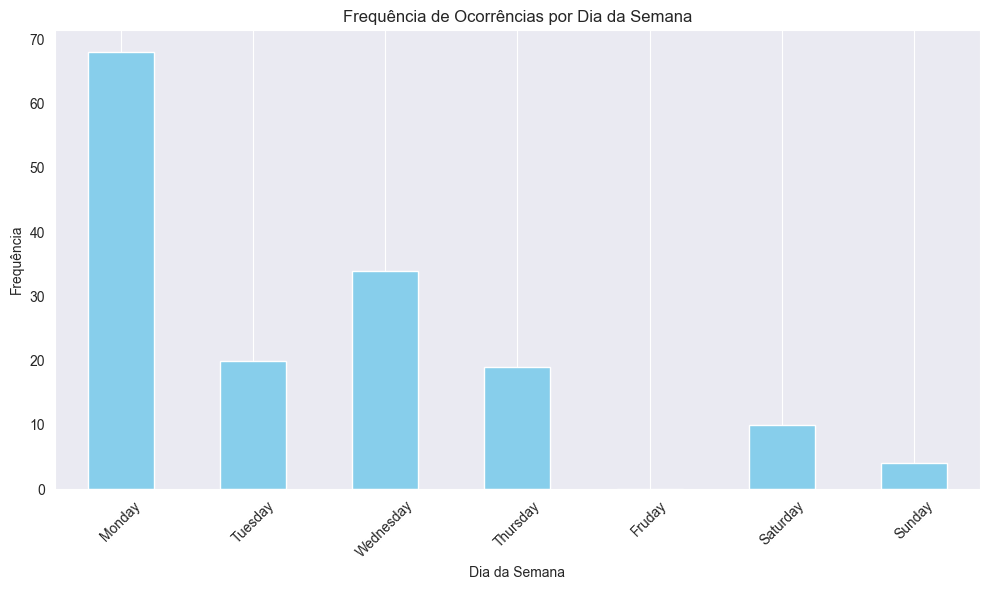

In [231]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar a frequência de cada dia da semana
frequencia_dias = gdf_sem_correspondencia['Dia da Semana'].value_counts()

# Reordenar o índice para que os dias da semana apareçam na ordem correta
dias_da_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Fruday', 'Saturday', 'Sunday']
frequencia_dias = frequencia_dias.reindex(dias_da_semana, fill_value=0)

# Gerar o histograma
plt.figure(figsize=(10, 6))
frequencia_dias.plot(kind='bar', color='skyblue')
plt.title('Frequência de Ocorrências por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Exibir o gráfico
plt.tight_layout()  # Ajustar layout
plt.show()

In [232]:
total_true = gdf_sem_correspondencia['Correspondencia'].sum()

# Contar o total de valores False
total_false = len(gdf_sem_correspondencia) - total_true

# Exibir os resultados
print(f"Total True: {total_true}")
print(f"Total False: {total_false}")

Total True: 0
Total False: 196


In [235]:
gdf_geosampa['data'].unique()

<DatetimeArray>
['2023-02-01 00:00:00', '2023-02-02 00:00:00', '2023-02-03 00:00:00',
 '2023-02-04 00:00:00', '2023-02-05 00:00:00', '2023-02-06 00:00:00',
 '2023-02-07 00:00:00', '2023-02-08 00:00:00', '2023-02-09 00:00:00',
 '2023-02-10 00:00:00',
 ...
 '2023-12-10 00:00:00', '2023-12-11 00:00:00', '2023-12-22 00:00:00',
 '2023-12-23 00:00:00', '2023-12-24 00:00:00', '2023-12-25 00:00:00',
 '2023-12-26 00:00:00', '2023-12-27 00:00:00', '2023-12-28 00:00:00',
 '2023-12-29 00:00:00']
Length: 123, dtype: datetime64[ms]

In [238]:
import numpy as np
import pandas as pd

# Passo 1: Converter as colunas de datas para o tipo datetime, se ainda não estiverem
#gdf_incidentes['data'] = pd.to_datetime(gdf_incidentes['data'])
#df_cge_processados['Data'] = pd.to_datetime(df_cge_processados['Data'])

# Passo 2: Criar colunas adicionais de ano e mês para ambos os DataFrames
gdf_geosampa['ano_mes'] = gdf_geosampa['data'].dt.to_period('M')  # Agrupa por ano e mês
df_cge_processados['ano_mes'] = df_cge_processados['Data'].dt.to_period('M')

# Passo 3: Inicializar um dicionário para armazenar o percentual de sobreposição por ano e mês
percentuais_sobreposicao = []

# Passo 4: Iterar sobre cada período (ano e mês) único no gdf ou no df
for periodo in gdf_geosampa['ano_mes'].unique():
    # Filtrar por esse período no gdf e no df
    gdf_periodo = gdf_geosampa[gdf_geosampa['ano_mes'] == periodo]
    df_periodo = df_cge_processados[df_cge_processados['ano_mes'] == periodo]
    
    # Identificar datas comuns
    datas_comuns = pd.Series(np.intersect1d(gdf_periodo['data'], df_periodo['Data']))
    
    # Calcular o total de datas exclusivas por período
    total_datas_gdf = gdf_periodo['data'].nunique()
    total_datas_df = df_periodo['Data'].nunique()
    
    # Calcular o percentual de sobreposição
    if total_datas_gdf > 0 and total_datas_df > 0:
        percentual_gdf = (datas_comuns.nunique() / total_datas_gdf) * 100
        percentual_df = (datas_comuns.nunique() / total_datas_df) * 100
    else:
        percentual_gdf = 0
        percentual_df = 0

    # Armazenar os resultados no dicionário
    percentuais_sobreposicao.append({
        'ano_mes': periodo,
        'percentual_Geosampa': percentual_gdf,
        'percentual_CGE': percentual_df
    })

# Converter o resultado para DataFrame para melhor visualização
df_resultado = pd.DataFrame(percentuais_sobreposicao)

# Arredondar os percentuais para uma casa decimal
df_resultado = df_resultado.round({'percentual_Geosampa': 1, 'percentual_CGE': 1})

# Converter 'ano_mes' para timestamp (datetime)
df_resultado['ano_mes'] = df_resultado['ano_mes'].apply(lambda x: x.to_timestamp())

# Ordenar pelo 'ano_mes'
df_resultado = df_resultado.sort_values(by='ano_mes')

# Exibir o DataFrame ordenado
print(df_resultado)

      ano_mes  percentual_Geosampa  percentual_CGE
2  2023-01-01                 83.3            78.9
0  2023-02-01                 60.7           100.0
1  2023-03-01                 55.0            91.7
3  2023-04-01                 28.6           100.0
4  2023-05-01                  0.0             0.0
5  2023-06-01                  0.0             0.0
6  2023-08-01                 50.0            66.7
7  2023-09-01                 75.0            75.0
8  2023-10-01                 60.0            69.2
9  2023-11-01                 70.0           100.0
10 2023-12-01                 33.3            66.7


In [166]:
# Passo 1: Converter 'ano_mes' para string, caso ainda não esteja
df_resultado['ano_mes'] = df_resultado['ano_mes'].astype(str)

# Passo 2: Criar a nova coluna 'Ano' a partir de 'ano_mes'
df_resultado['Ano'] = df_resultado['ano_mes'].str[:4]  # Extrai os primeiros 4 caracteres de 'ano_mes' como o ano

# Passo 3: Agrupar por ano e exibir cada tabela separadamente
for ano, grupo in df_resultado.groupby('Ano'):
    print(f'\nSobreposição de Datas - Ano: {ano}')
    print(grupo.to_string(index=False))



Sobreposição de Datas - Ano: 2013
ano_mes  percentual_Geosampa  percentual_CGE  Ano
2013-12                 80.0            80.0 2013
2013-11                 88.9            80.0 2013
2013-10                 88.9           100.0 2013
2013-09                100.0           100.0 2013
2013-08                  0.0             0.0 2013
2013-07                100.0            66.7 2013
2013-06                 83.3            62.5 2013
2013-04                 71.4           100.0 2013
2013-02                 85.7            75.0 2013
2013-01                 57.1            72.7 2013
2013-03                 66.7           100.0 2013

Sobreposição de Datas - Ano: 2014
ano_mes  percentual_Geosampa  percentual_CGE  Ano
2014-10                100.0           100.0 2014
2014-11                 72.7           100.0 2014
2014-12                 66.7            88.9 2014
2014-01                 66.7            92.3 2014
2014-02                 54.5            75.0 2014
2014-03                 72.2  

In [ ]:
# TODO Verificar se os eventos estão ocorrendo no mesmo lugar, entre GeoSampa e CGE

### Preparação dos pacotes de simulação

{0: {'Name': 'Sé - CGE (PMSP/SE-01)', 'Estacao': '0', 'Posto': 503}, 1: {'Name': 'Sé - Anhembi (PMSP/SE-02)', 'Estacao': '1', 'Posto': 1000866}, 2: {'Name': 'Vila Mariana (PMSP/VM-01)', 'Estacao': '2', 'Posto': 495}, 3: {'Name': 'Ipiranga (PMSP/IP-01)', 'Estacao': '3', 'Posto': 1000840}, 4: {'Name': 'Campo Limpo (PMSP/CL-03)', 'Estacao': '4', 'Posto': 1000854}, 5: {'Name': 'M Boi Mirim (PMSP/MB-01)', 'Estacao': '5', 'Posto': 1000850}, 6: {'Name': 'Santo Amaro (PMSP/SA-01)', 'Estacao': '6', 'Posto': 1000852}, 7: {'Name': 'Jabaquara (PMSP/JA-01)', 'Estacao': '7', 'Posto': 634}, 8: {'Name': 'Cidade Ademar - (PMSP/AD-01) / São Paulo', 'Estacao': '8', 'Posto': 592}, 9: {'Name': 'Capela do Socorro (PMSP/CS-01)', 'Estacao': '9', 'Posto': 846}, 10: {'Name': 'Parelheiros - Barragem (PMSP/PA-01)', 'Estacao': '10', 'Posto': 507}, 11: {'Name': 'Estação Meteorológica Marsilac', 'Estacao': '11', 'Posto': 1000300}, 12: {'Name': 'Mooca (PMSP/MO-01)', 'Estacao': '12', 'Posto': 1000860}, 13: {'Name': 'P

In [239]:
# Após reunião do projeto, acordamos realizar a simulação dentro do seguinte período:
# Início: Janeiro de 2023
# Término: Março de 2023
# Motivos: data mais recente, pós-pandemia, onde todos os dados estão presentes e com uma boa quantidade de eventos. 

In [240]:
from datetime import datetime, timedelta
import pandas as pd

In [241]:
# Função para ajustar horários sem ultrapassar os limites do dia
def ajustar_horarios(horario, ajuste, dia):
    try:
        # Convertendo o horário para datetime e aplicando o ajuste
        horario_dt = pd.to_datetime(horario, format='%H:%M:%S', errors='coerce')
        
        # Verificar se o horário foi convertido corretamente
        if pd.isna(horario_dt):
            print(f"Formato de horário inválido: '{horario_dt}' na data {data}")
            return None  # Retorna None para horários inválidos
        
        # Combinar a data com o horário (para que ele carregue o dia correto)
        horario_completo = datetime.combine(pd.to_datetime(dia).date(), horario_dt.time())
        
        # Aplicar o ajuste de horas
        horario_ajustado = horario_completo + timedelta(hours=ajuste)
               
        # Retorna o horário e a data ajustada
        return horario_ajustado.strftime('%Y-%m-%d %H:%M:%S')
    
    except Exception as e:
        print(f"Erro ao ajustar horário: {e}")
        return None

In [251]:
novo_df = pd.DataFrame()

# Parâmetros de ajuste
ajuste_inicio = -2  # Duas horas antes do horário inicial
ajuste_fim = 2  # Duas horas depois do horário final

# Lista de resultados para armazenar os dados de cada iteração
resultados = []

# Filtrar as datas para o ano de 2023 e meses de janeiro, fevereiro e março
datas_filtradas = gdf_geosampa[gdf_geosampa['data'].dt.year == 2023]  # Filtra pelo ano de 2023
datas_filtradas = datas_filtradas[datas_filtradas['data'].dt.month.isin([1, 2, 3])]  # Filtra pelos meses de jan, fev, mar

# Extraindo as datas únicas
datas_unicas = datas_filtradas['data'].dt.date.unique()

In [252]:
# Iterando sobre cada data única
for dia in datas_unicas:
    
    # Verificando se a data existe no df_cge
    if dia in df_cge_processados['Data'].dt.date.unique():
        # Filtrando o DataFrame para a data específica
        df_filtrado = df_cge_processados[df_cge_processados['Data'].dt.date == dia]
        
        # Selecionando o horário mais cedo e o mais tarde
        horario_inicial = df_filtrado['Horário Inicial'].min()
        #print('Horário mais cedo: ', horario_inicial)
        horario_final = df_filtrado['Horário Final'].max()
        #print('Horário mais tarde: ', horario_final)
        
        # Calculando os horários de simulação ajustados
        simulacao_inicio = ajustar_horarios(horario_inicial, ajuste_inicio, dia)
        simulacao_final = ajustar_horarios(horario_final, ajuste_fim, dia)
        #print(f'Data mais cedo: {horario_inicial}, início da simulação: {simulacao_inicio}')
        
        # Verificar se a simulação_inicio e simulacao_final ocorreram no mesmo dia
        data_original = pd.to_datetime(dia).date()

        # Extrair a data e hora da simulação início e fim
        data_simul_ini = pd.to_datetime(simulacao_inicio).date()
        hora_simul_ini = pd.to_datetime(simulacao_inicio).time()

        data_simul_fim = pd.to_datetime(simulacao_final).date()
        hora_simul_fim = pd.to_datetime(simulacao_final).time()

        # Definir Data_Simul_Ini e Data_Simul_Fim com base na diferença de dias
        if data_simul_ini == data_original:
            data_simul_ini = data_original
        else:
            data_simul_ini = data_simul_ini  # Pode ser o dia anterior

        if data_simul_fim == data_original:
            data_simul_fim = data_original
        else:
            data_simul_fim = data_simul_fim  # Pode ser o dia posterior

        # Adicionando as informações à lista de resultados
        resultados.append({
            'Data evento': dia,
            'Horário Inicial': horario_inicial,
            'Horário Final': horario_final,
            'Data_Simul_Ini': data_simul_ini,
            'Data_Simul_Fim': data_simul_fim,
            'Simulação Início': hora_simul_ini,
            'Simulação Final': hora_simul_fim,
            'Tipo': 'Detalhado'
})

        
    else:
        # Caso a data não exista no df_cge, adicionar o dia inteiro
        horario_inicial = '00:00:00'
        horario_final = '23:59:59'
        
        # Calculando os horários de simulação ajustados
        simulacao_inicio = horario_inicial
        simulacao_final = horario_final
        
        resultados.append({
            'Data evento': dia,
            'Horário Inicial': horario_inicial,
            'Horário Final': horario_final,
            'Data_Simul_Ini': dia,
            'Data_Simul_Fim': dia,
            'Simulação Início': simulacao_inicio,
            'Simulação Final': simulacao_final,
            'Tipo': 'Inteiro'
        })

# Criando um DataFrame a partir da lista de resultados
novo_df = pd.DataFrame(resultados)

In [261]:
novo_df

,Data evento,Horário Inicial,Horário Final,Data_Simul_Ini,Data_Simul_Fim,Simulação Início,Simulação Final,Tipo,datetime_inicio,datetime_fim,horas_simuladas
0,2023-02-01,06:25:00,22:31:00,2023-02-01,2023-02-02,04:25:00,00:31:00,Detalhado,2023-02-01 04:25:00,2023-02-02 00:31:00,20.0
1,2023-02-02,08:50:00,21:35:00,2023-02-02,2023-02-02,06:50:00,23:35:00,Detalhado,2023-02-02 06:50:00,2023-02-02 23:35:00,17.0
2,2023-02-03,00:00:00,23:59:59,2023-02-03,2023-02-03,00:00:00,23:59:59,Inteiro,2023-02-03 00:00:00,2023-02-03 23:59:59,24.0
3,2023-02-04,00:00:00,23:59:59,2023-02-04,2023-02-04,00:00:00,23:59:59,Inteiro,2023-02-04 00:00:00,2023-02-04 23:59:59,24.0
4,2023-02-05,00:00:00,23:59:59,2023-02-05,2023-02-05,00:00:00,23:59:59,Inteiro,2023-02-05 00:00:00,2023-02-05 23:59:59,24.0
...,...,...,...,...,...,...,...,...,...,...,...
61,2023-03-20,17:35:00,18:14:00,2023-03-20,2023-03-20,15:35:00,20:14:00,Detalhado,2023-03-20 15:35:00,2023-03-20 20:14:00,5.0
62,2023-03-27,02:15:00,02:38:00,2023-03-27,2023-03-27,00:15:00,04:38:00,Detalhado,2023-03-27 00:15:00,2023-03-27 04:38:00,4.0
63,2023-03-28,00:00:00,23:59:59,2023-03-28,2023-03-28,00:00:00,23:59:59,Inteiro,2023-03-28 00:00:00,2023-03-28 23:59:59,24.0
64,2023-03-30,00:00:00,23:59:59,2023-03-30,2023-03-30,00:00:00,23:59:59,Inteiro,2023-03-30 00:00:00,2023-03-30 23:59:59,24.0


In [262]:
# Converter as colunas 'Data_Simul_Ini' e 'Simulação Início' para um único datetime
novo_df['datetime_inicio'] = pd.to_datetime(novo_df['Data_Simul_Ini'].astype(str) + ' ' + novo_df['Simulação Início'].astype(str))

# Converter as colunas 'Data_Simul_Fim' e 'Simulação Final' para um único datetime
novo_df['datetime_fim'] = pd.to_datetime(novo_df['Data_Simul_Fim'].astype(str) + ' ' + novo_df['Simulação Final'].astype(str))

# Calcular a diferença em horas entre o início e o fim da simulação
novo_df['horas_simuladas'] = ((novo_df['datetime_fim'] - novo_df['datetime_inicio']).dt.total_seconds() / 3600).round(0)

In [263]:
novo_df.describe()

,datetime_inicio,datetime_fim,horas_simuladas
count,66,66,66.000000
mean,2023-02-15 08:30:53.636363520,2023-02-15 23:43:31.469697280,15.212121
min,2023-01-03 14:20:00,2023-01-04 00:32:00,4.000000
25%,2023-01-30 09:44:45,2023-01-31 06:16:14.249999872,8.000000
50%,2023-02-16 01:50:30,2023-02-16 10:26:30,14.000000
75%,2023-03-05 09:45:00,2023-03-06 05:26:14.249999872,24.000000
max,2023-03-31 11:52:00,2023-03-31 17:48:00,25.000000
std,NaN,NaN,7.851536


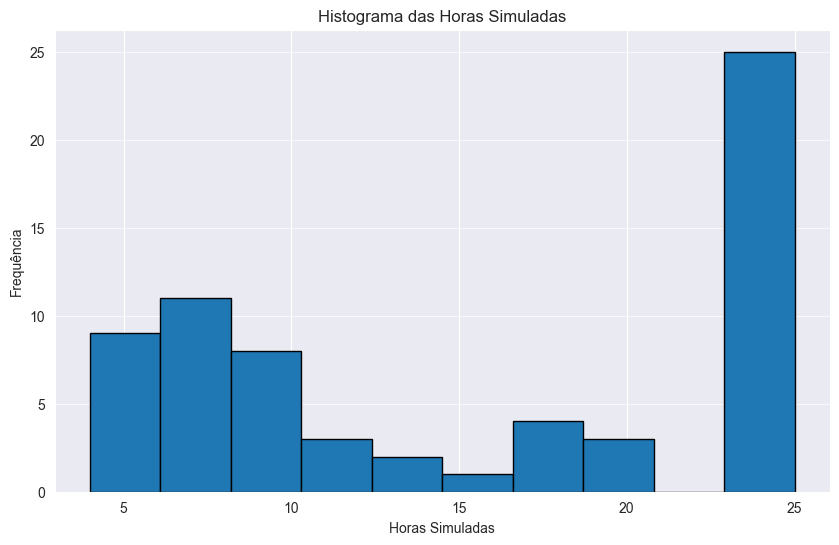

In [264]:
# Criar o histograma
plt.figure(figsize=(10, 6))
plt.hist(novo_df['horas_simuladas'], bins=10, edgecolor='black')
plt.title('Histograma das Horas Simuladas')
plt.xlabel('Horas Simuladas')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [275]:
# Contar quantas linhas têm mais de 24 horas
contagem = (novo_df['horas_simuladas'] > 23).sum()

print(f"Número de linhas com mais de 23 horas: {contagem}")

Número de linhas com mais de 23 horas: 25


In [267]:
novo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data evento       66 non-null     object        
 1   Horário Inicial   66 non-null     object        
 2   Horário Final     66 non-null     object        
 3   Data_Simul_Ini    66 non-null     object        
 4   Data_Simul_Fim    66 non-null     object        
 5   Simulação Início  66 non-null     object        
 6   Simulação Final   66 non-null     object        
 7   Tipo              66 non-null     object        
 8   datetime_inicio   66 non-null     datetime64[ns]
 9   datetime_fim      66 non-null     datetime64[ns]
 10  horas_simuladas   66 non-null     float64       
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 5.8+ KB


In [269]:
novo_df['horas_simuladas'] > 20

0     False
1     False
2      True
3      True
4      True
      ...  
61    False
62    False
63     True
64     True
65    False
Name: horas_simuladas, Length: 66, dtype: bool

In [147]:
# Filtrar o GeoDataFrame para a data específica
df_filtrado = novo_df[novo_df['Tipo'] == 'Detalhado']

# Exibir o resultado
print(df_filtrado)

           Data Horário Inicial Horário Final Simulação Início  \
0    2015-12-27        01:44:00      18:43:00         00:00:01   
1    2015-12-26        18:51:00      23:44:00         16:51:00   
2    2015-12-29        01:07:00      23:06:00         00:00:01   
3    2015-12-30        00:05:00      22:52:00         00:00:01   
4    2015-12-20        15:28:00      22:20:00         13:28:00   
..          ...             ...           ...              ...   
115  2015-01-01        18:52:00      20:35:00         16:52:00   
116  2015-01-02        18:02:00      18:52:00         16:02:00   
117  2015-01-03        18:20:00      22:42:00         16:20:00   
118  2015-01-05        14:36:00      19:09:00         12:36:00   
119  2015-01-06        17:22:00      20:01:00         15:22:00   

    Simulação Final       Tipo  
0          20:43:00  Detalhado  
1          23:59:59  Detalhado  
2          23:59:59  Detalhado  
3          23:59:59  Detalhado  
4          23:59:59  Detalhado  
..       

In [143]:
## Função para combinar data e hora (tratando strings e objetos time)
def combinar_data_hora(data_str, horario):
    data = pd.to_datetime(data_str)  # Converter string para datetime (apenas data)
    
    # Se o horário for string, converte para time, caso contrário, usa o time diretamente
    if isinstance(horario, str):
        horario = datetime.strptime(horario, '%H:%M').time()  # Converter string para time
    
    return datetime.combine(data.date(), horario)

# Aplicar a função para combinar a data com os horários
novo_df['Simulação Início Completo'] = novo_df.apply(lambda row: combinar_data_hora(row['Data'], row['Simulação Início']), axis=1)
novo_df['Simulação Final Completo'] = novo_df.apply(lambda row: combinar_data_hora(row['Data'], row['Simulação Final']), axis=1)

# Calcular a diferença em horas entre 'Simulação Início Completo' e 'Simulação Final Completo'
novo_df['Diferença em Horas'] = (novo_df['Simulação Final Completo'] - novo_df['Simulação Início Completo']).dt.total_seconds() / 3600

# Exibir o dataframe com a nova coluna
print(novo_df[['Simulação Início Completo', 'Simulação Final Completo', 'Diferença em Horas']])

ValueError: unconverted data remains: :00